<a href="https://colab.research.google.com/github/hunny1123/KorenCollaborativeFiltering2008/blob/master/NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!curl -O 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!unzip ml-100k.zip
!mkdir -p data

!cp ml-100k/u.data data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0   9.8M      0 --:--:-- --:--:-- --:--:--  9.9M
Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base

In [64]:
import pandas as pd
import numpy as np

In [65]:
import os
os.getcwd()

'/content'

In [66]:
input_file = 'data/u.data'
headers = ['user_id', 'item_id', 'rating', 'timestamp']
header_row = None
ratings_df = pd.read_csv(input_file,
                         sep='\t',
                         names=headers,
                         header=header_row,
                         dtype={
                           'user_id': np.int32,
                           'item_id': np.int32,
                           'rating': np.float32,
                           'timestamp': np.int32,
                         })

In [67]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [68]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [69]:
user_enc = LabelEncoder()
product_enc = LabelEncoder()
scaler = MinMaxScaler()

ratings_df['user_id'] = user_enc.fit_transform(ratings_df['user_id'].values)
ratings_df['item_id'] = product_enc.fit_transform(ratings_df['item_id'].values)
ratings_df['rating'] = scaler.fit_transform(ratings_df['rating'].values.reshape(-1, 1))

In [70]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,195,241,0.50,881250949
1,185,301,0.50,891717742
2,21,376,0.00,878887116
3,243,50,0.25,880606923
4,165,345,0.00,886397596


In [71]:
n_users = len(ratings_df['user_id'].unique())
n_items = len(ratings_df['item_id'].unique())

In [72]:
print('number of unique user {}'.format(n_users))
print('number of unique movie {}'.format(n_items))

number of unique user 943
number of unique movie 1682


In [73]:
ratings_df['user_id'].min() # make sure index start from 0

0

In [74]:
ratings = ratings_df[['user_id','item_id','rating']].to_numpy()

In [75]:
from sklearn.model_selection import train_test_split

tr_ratings, ts_ratings = train_test_split(ratings, test_size = 0.1)
X_train = [[tr_ratings[:,0],tr_ratings[:,1]]]
y_train = tr_ratings[:,2].reshape(-1,1)

X_test = [[ts_ratings[:,0],ts_ratings[:,1]]]
y_test = ts_ratings[:,2].reshape(-1,1)

In [76]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [77]:
def build_GMF(embedding_dim, n_users, n_items):
  # Input layers
  user_input = tf.keras.layers.Input(shape=(1,)) # user
  product_input = tf.keras.layers.Input(shape=(1,)) # movie
  # Embedding layers
  User_embedding = tf.keras.layers.Embedding(n_users, embedding_dim,embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
  Product_embedding = tf.keras.layers.Embedding(n_items, embedding_dim, embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)
  # Dot products
  u = tf.keras.layers.Reshape((embedding_dim,))(User_embedding)
  v = tf.keras.layers.Reshape((embedding_dim,))(Product_embedding)
  s = tf.keras.layers.Dot(axes=1)([u, v])
  model = tf.keras.Model(inputs=[user_input, product_input], outputs=s)
  print(model.summary())
  return(model)

In [78]:
embedding_dim = 10
GMF_model = build_GMF(embedding_dim, n_users, n_items)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 1, 10)        9430        ['input_15[0][0]']               
                                                                                                  
 embedding_19 (Embedding)       (None, 1, 10)        16820       ['input_16[0][0]']               
                                                                                            

In [79]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [80]:
opt = tf.keras.optimizers.Adagrad(learning_rate=0.5)  #Use Adagrad to get faster learning rate
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)  

GMF_model.compile(loss='mean_squared_error', optimizer=opt)

history = GMF_model.fit(x=X_train, y=y_train,
                  batch_size=64, epochs=10,
                  validation_data= (X_test, y_test),
                  callbacks=[checkpoint_callback, es])

Epoch 1/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4559 - val_loss: 0.3056
Epoch 2/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.1373 - val_loss: 0.0837
Epoch 3/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.0695 - val_loss: 0.0672
Epoch 4/10
1407/1407 [==============================] - 2s 2ms/step - loss: 0.0610 - val_loss: 0.0630
Epoch 5/10
1407/1407 [==============================] - 2s 2ms/step - loss: 0.0578 - val_loss: 0.0607
Epoch 6/10
1407/1407 [==============================] - 2s 2ms/step - loss: 0.0557 - val_loss: 0.0593
Epoch 7/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.0538 - val_loss: 0.0582
Epoch 8/10
1407/1407 [==============================] - 2s 2ms/step - loss: 0.0520 - val_loss: 0.0576
Epoch 9/10
1407/1407 [==============================] - 2s 2ms/step - loss: 0.0503 - val_loss: 0.0569
Epoch 10/10
1407/1407 [==============================] - 2s 2ms/step - loss: 0.048

In [81]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

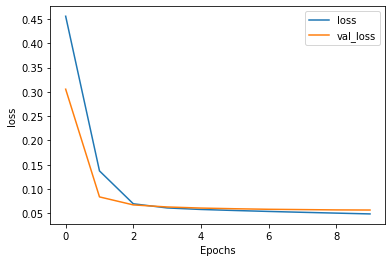

In [82]:
plot_graph(history, "loss")

In [83]:
recovered_model = build_GMF(embedding_dim, n_users, n_items)
recovered_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
recovered_model.build(tf.TensorShape([1, None]))

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 1, 10)        9430        ['input_17[0][0]']               
                                                                                                  
 embedding_21 (Embedding)       (None, 1, 10)        16820       ['input_18[0][0]']               
                                                                                            

In [84]:
prediction = recovered_model(X_test)

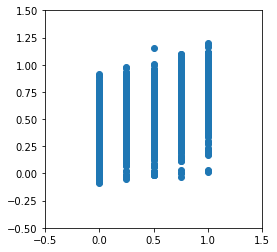

In [85]:
plt.plot(y_test,prediction,'o')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

In [86]:
def build_bias(embedding_dim, n_users, n_items):
    # Input layers
    user_input = tf.keras.layers.Input(shape=(1,)) # user
    product_input = tf.keras.layers.Input(shape=(1,)) # movie
    # Embedding layers
    User_embedding = tf.keras.layers.Embedding(n_users, embedding_dim,embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)

    User_embedding_avg = tf.keras.layers.Embedding(n_users, 1,embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)


    Product_embedding = tf.keras.layers.Embedding(n_items, embedding_dim,embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)

    Product_embedding_avg = tf.keras.layers.Embedding(n_items, 1,embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)


    # Dot products
    u = tf.keras.layers.Reshape((embedding_dim,))(User_embedding)
    v = tf.keras.layers.Reshape((embedding_dim,))(Product_embedding)
    s = tf.keras.layers.Dot(axes=1)([u, v])

    o = tf.keras.layers.Add()([s, User_embedding_avg, Product_embedding_avg])

    model = tf.keras.Model(inputs=[user_input, product_input], outputs=o)
    print(model.summary())
    return(model)

In [87]:
def build_MLP(embedding_dim, n_users, n_items):
    # Input layers
    user_input_mlp = tf.keras.layers.Input(shape=(1,)) # user
    product_input_mlp = tf.keras.layers.Input(shape=(1,)) # movie
    # Embedding layers
    User_embedding_mlp = tf.keras.layers.Embedding(n_users, embedding_dim,
                                                 embeddings_initializer= "normal",
                                                  embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input_mlp)
    Product_embedding_mlp = tf.keras.layers.Embedding(n_items, embedding_dim, 
                                                    embeddings_initializer= "normal",
                                                    embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input_mlp)
    # Concatenation of the two embedding
    # u_mlp = tf.keras.layers.Flatten()(User_embedding_mlp)
    # v_mlp = tf.keras.layers.Flatten()(Product_embedding_mlp)

    u_mlp =tf.keras.layers.Reshape((embedding_dim,))(User_embedding_mlp)
    v_mlp = tf.keras.layers.Reshape((embedding_dim,))(Product_embedding_mlp)

    u_mlp = tf.keras.layers.Dropout(0.5)(u_mlp)
    v_mlp = tf.keras.layers.Dropout(0.5)(v_mlp)

    merged = tf.keras.layers.Concatenate(axis=1)([u_mlp, v_mlp])

    fcn = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-6),
                              activity_regularizer = tf.keras.regularizers.l2(1e-6))(merged)

    fcn = tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)

    fcn = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)
    fcn = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)

    output_mlp = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer="lecun_uniform")(fcn)

    model = tf.keras.Model(inputs=[user_input_mlp, product_input_mlp], outputs=output_mlp)
    print(model.summary())
    return(model)

In [88]:
embedding_dim = 100
MLP_model = build_MLP(embedding_dim, n_users, n_items)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 1, 100)       94300       ['input_19[0][0]']               
                                                                                                  
 embedding_23 (Embedding)       (None, 1, 100)       168200      ['input_20[0][0]']               
                                                                                            

In [89]:
# opt = tf.keras.optimizers.Adagrad(learning_rate=0.01)  #Use Adagrad to get faster learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.001)  

MLP_model.compile(loss='mean_squared_error', optimizer=opt)

history = MLP_model.fit(x=X_train, y=y_train,
                  batch_size=64, epochs=10,
                  validation_data= (X_test, y_test),
                  callbacks=[checkpoint_callback, es])

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.0625 - val_loss: 0.0583
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0560 - val_loss: 0.0569
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0548 - val_loss: 0.0567
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0541 - val_loss: 0.0566
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0536 - val_loss: 0.0571
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0531 - val_loss: 0.0563
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0522 - val_loss: 0.0564
Epoch 8/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0515 - val_loss: 0.0561
Epoch 9/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0510 - val_loss: 0.0561
Epoch 10/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.050

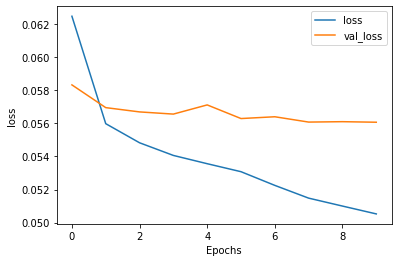

In [90]:
plot_graph(history, "loss")

In [91]:
recovered_model = build_GMF(embedding_dim, n_users, n_items)
recovered_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
recovered_model.build(tf.TensorShape([1, None]))

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 1, 100)       94300       ['input_21[0][0]']               
                                                                                                  
 embedding_25 (Embedding)       (None, 1, 100)       168200      ['input_22[0][0]']               
                                                                                           

In [92]:
prediction = recovered_model(X_test)

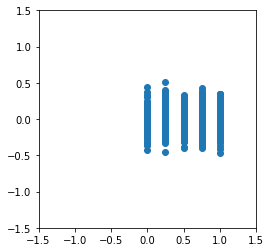

In [93]:
plt.plot(y_test,prediction,'o')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

In [101]:
def build_NCF(embedding_dim, n_users, n_items):
    user_input = tf.keras.layers.Input(shape=(1,)) # user
    product_input = tf.keras.layers.Input(shape=(1,)) # movie

    # Embedding of GMF
    User_embedding_gmf = tf.keras.layers.Embedding(n_users, embedding_dim,
                                             embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
    Product_embedding_gmf = tf.keras.layers.Embedding(n_items, embedding_dim,
                                                embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)

    # Embedding of MLP
    User_embedding_mlp = tf.keras.layers.Embedding(n_users, embedding_dim,
                                            embeddings_initializer= "normal",
                                            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
    Product_embedding_mlp = tf.keras.layers.Embedding(n_items, embedding_dim, 
                                                    embeddings_initializer= "normal",
                                                    embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)

    # GMF: Matrix Multiplication
    u = tf.keras.layers.Flatten()(User_embedding_gmf)
    v = tf.keras.layers.Flatten()(Product_embedding_gmf)
    output_gmf = tf.keras.layers.Dot(axes=1)([u, v])

    # MLP: Concatenation of the two embedding
    u_mlp = tf.keras.layers.Flatten()(User_embedding_mlp)
    v_mlp = tf.keras.layers.Flatten()(Product_embedding_mlp)

    u_mlp = tf.keras.layers.Dropout(0.5)(u_mlp)
    v_mlp = tf.keras.layers.Dropout(0.5)(v_mlp)

    merged_mlp = tf.keras.layers.Concatenate(axis=1)([u_mlp, v_mlp])


    fcn = tf.keras.layers.Dense(64, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-6),
                              activity_regularizer = tf.keras.regularizers.l2(1e-6))(merged_mlp)

    fcn = tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)

    fcn = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)
    output_mlp = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)

    #merge two output
    merged = tf.keras.layers.Concatenate(axis=1)([output_mlp, output_gmf])
    output = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer="lecun_uniform")(merged)

    model = tf.keras.Model(inputs=[user_input, product_input], outputs=output)
    print(model.summary())
    return(model)

In [95]:
embedding_dim = 100
NCF_model = build_NCF(embedding_dim, n_users, n_items)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_28 (Embedding)       (None, 1, 100)       94300       ['input_23[0][0]']               
                                                                                                  
 embedding_29 (Embedding)       (None, 1, 100)       168200      ['input_24[0][0]']               
                                                                                           

In [96]:
opt = tf.keras.optimizers.Adagrad(learning_rate=0.5)  #Use Adagrad to get faster learning rate
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)  

NCF_model.compile(loss='mean_squared_error', optimizer=opt)

history = NCF_model.fit(x=X_train, y=y_train,
                  batch_size=64, epochs=10,
                  validation_data= (X_test, y_test),
                  callbacks=[checkpoint_callback, es])

Epoch 1/10
1407/1407 [==============================] - 14s 9ms/step - loss: 0.0715 - val_loss: 0.0626
Epoch 2/10
1407/1407 [==============================] - 9s 7ms/step - loss: 0.0598 - val_loss: 0.0586
Epoch 3/10
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0576 - val_loss: 0.0588
Epoch 4/10
1407/1407 [==============================] - 9s 7ms/step - loss: 0.0562 - val_loss: 0.0575
Epoch 5/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.0554 - val_loss: 0.0570
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.0549 - val_loss: 0.0571
Epoch 7/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.0543 - val_loss: 0.0571
Epoch 8/10
1407/1407 [==============================] - 9s 7ms/step - loss: 0.0539 - val_loss: 0.0569
Epoch 9/10
1407/1407 [==============================] - 9s 7ms/step - loss: 0.0536 - val_loss: 0.0570
Epoch 10/10
1407/1407 [==============================] - 9s 7ms/step - loss: 0.0

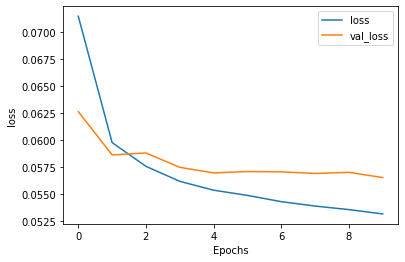

In [97]:
plot_graph(history, "loss")

In [98]:
recovered_model = build_NCF(embedding_dim, n_users, n_items)
recovered_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
recovered_model.build(tf.TensorShape([1, None]))

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_32 (Embedding)       (None, 1, 100)       94300       ['input_25[0][0]']               
                                                                                                  
 embedding_33 (Embedding)       (None, 1, 100)       168200      ['input_26[0][0]']               
                                                                                           

In [99]:
prediction = recovered_model(X_test)

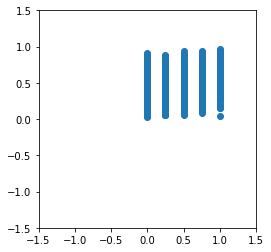

In [100]:
plt.plot(y_test,prediction,'o')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')